## Phase 1 training with stochastic channel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pandas as pd

from keras.layers import Dense
from keras.models import Sequential,Model
from scipy.stats import nakagami

from tensorflow.keras.optimizers import Adam


In [2]:
# Variables Initialization

k = 3
M = 2**k
NUM_CHANNEL_USES = 1
block_size = 320

model_training_num_of_frames = 10**3#10**4
model_validating_num_of_frames = 10**2#10**3

n_train = block_size * model_training_num_of_frames
n_val   = block_size * model_validating_num_of_frames

# Geanerating dataset
model_output_num_of_frames = 10**5
n_out = block_size * model_output_num_of_frames 

num_epoches = 10

#Definig noise standard deviation 
# We use a constant symbol (iq) rate and we assume a constance signal power of 1
"""
When the normalization_mode = 'iq' , every iq sample has the power of 1. When we are using time diversity, we use only one path to send different channel uses (symbols) for a msg.
When the normalization_mode = 'range' , the total power for all the channel uses, are 1. 
When the normalization_mode = 'msg', we normalize over all the channel uses
"""
EbNo_dB = 10
fs = 125*10**3
B = 2*fs*(1+0.5)*0.5     # 187500.0
Normalization_mode = 'iq' 
EbNo = 10**(EbNo_dB/10)
noise_std = (B*NUM_CHANNEL_USES/(2*fs*EbNo*k))**0.5
print(f"Noise std {noise_std}")


Noise std 0.15811388300841897


In [3]:
    
class L2Normalization(tf.keras.layers.Layer):   # Normalize all the channel uses 
    def __init__(self,**kwargs):
        super(L2Normalization, self).__init__(**kwargs)
    def call(self, inputs):
        out = tf.nn.l2_normalize(inputs, axis=-1)
        print("normalize output shape = ",out.shape)
        return out
    def get_config(self):
        return super(L2Normalization, self).get_config()
    
class Normalization_layer_iq(tf.keras.layers.Layer): # Normalize iq samples (power = 1)
    def __init__(self,**kwargs):
        super(Normalization_layer_iq, self).__init__(**kwargs)
    def call(self, inputs):
        out = tf.nn.l2_normalize(tf.reshape(inputs,(-1,2)), axis=-1)
        print("normalize output shape 1 = ",out.shape)
        out = tf.reshape(out,(-1,2*NUM_CHANNEL_USES))
        print("normalize output shape 2 = ",out.shape)
        return out
    def get_config(self):
        return super(Normalization_layer_iq, self).get_config()
    

class Normalization_layer_iq_range(tf.keras.layers.Layer): # Normalize iq samples (in the range of 0.5 and 1)
    def __init__(self,**kwargs):
        super(Normalization_layer_iq_range, self).__init__(**kwargs)
    def call(self, inputs):
        out = 0.5*tf.where(inputs>0,1.0,0.0) + tf.math.sigmoid(tf.nn.relu(inputs)) - 0.5*tf.where(inputs>0,0.0,1) - tf.math.sigmoid(tf.nn.relu(-inputs))     # push the i and q values in between 0.5 and 1 and -0.5 and -1
        print("range normalize output shape 1 = ",out.shape)
        out = tf.reshape(out,(-1,2*NUM_CHANNEL_USES))
        print("range normalize output shape 2 = ",out.shape)
        return out
    def get_config(self):
        return super(Normalization_layer_iq_range, self).get_config()
    
class NakagamiNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, name,distribution_params, **kwargs):
        super(NakagamiNoiseLayer, self).__init__(name=name,**kwargs)
        self.distribution_params = distribution_params
    def call(self, inputs, training=False):
        print(inputs.shape)
        inputs = tf.reshape(inputs,(1,-1))[0]   
        fading = nakagami.rvs(self.distribution_params["m"],size=2*NUM_CHANNEL_USES*block_size)*nakagami_scale
        print("inputs = ",inputs.shape)
        print("fading = ",fading.shape)
        out = inputs * fading
        return tf.reshape(out,(-1,2*NUM_CHANNEL_USES))
        
class CustomNoise(tf.keras.layers.Layer):
  def __init__(self, mean=0.0, stddev=1.0, **kwargs):
    super(CustomNoise, self).__init__(**kwargs)
    self.mean = mean
    self.stddev = stddev

  def call(self, inputs, training=None):
    # Add noise regardless of training state
    noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
    return inputs + noise


In [4]:
# Making the stochasticChannelLayer

from scipy.stats import truncnorm
from scipy.stats import uniform


channel_parameters = {
    "r"        : 4,             # For upsampling -> number of complex samples per symbol
    "roll_off" : 0.35,          # Roll off factor
    "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
    "f_s"      : 25e4,          # Add what is in the physical implementation
    "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1) 
    #"time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
    "CFO"      : 5e3,           # Observe from the physical implementation
    "CFO_std"  : 5e3/25e4,      # CFO/f_s this is the normalized intersampled phase offset
    "noise_std": noise_std,     # noise power will be calculating assuming transmittting power of 1 
    "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
}

nakagami_scale = 1 # For normal nakagami effects (we can change this and have different scale of nakagami)


# function to create the complex values
def real_to_complex_tensor(inp_tensor):
  inp_tensor = tf.reshape(inp_tensor, [-1, 2])
  real_part = inp_tensor[:, 0]
  imag_part = inp_tensor[:, 1]
  complex_tensor = tf.complex(real_part, imag_part)
  return complex_tensor

def complex_to_real_tensor(inp_tensor):
   real_part , imag_part = tf.math.real(inp_tensor), tf.math.imag(inp_tensor)
   real_part = tf.reshape(real_part,[-1,1])
   imag_part = tf.reshape(imag_part,[-1,1])
   return tf.reshape(tf.concat([real_part,imag_part],1),[-1])

# Upsample
def upsampling(inp,r):
  com_reshape = tf.reshape(inp,[-1,1])
  padding = tf.constant([[0,0],[0,r-1]])
  upsampled = tf.pad(com_reshape,padding,"CONSTANT")
  return tf.reshape(upsampled,[-1])

# Normalized RRC with time shift
def NRRC_filter(num_taps, roll_off):
  time_delay =  np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
  print("time_delay - ",time_delay)
  t = np.linspace(-(num_taps-1)/2,(num_taps-1)/2,num_taps) - time_delay
  eps = np.finfo(float).eps # Small epsilon to avoid divisiomn by zero
  pi = np.pi
  def RRC_filter_coff(t):
    if abs(t) < eps:  # For t==0
      return 1.0 - roll_off + (4*roll_off/pi)
    elif roll_off != 0 and (abs(t-1/(4*roll_off))<eps or abs(t+1/(4*roll_off))<eps):
      return (roll_off/np.sqrt(2))*(1 + 2/pi)*np.sin(pi/(4*roll_off)) + (1- 2/pi)*np.cos(pi/(4*roll_off))
    else:
      nu = np.sin(pi*t*(1-roll_off)) + 4*roll_off*t*np.cos(pi*t*(1+roll_off))
      den = pi*t*(1-(4*roll_off*t)**2)
      return nu/(den + eps)
  filter_coff = np.array([RRC_filter_coff(T) for T in t])
  NRRC_filter_coff = filter_coff / np.sum(np.abs(filter_coff))
  plt.stem(t,NRRC_filter_coff)  # Plot for visualization
  plt.title(f"Time_delay = {time_delay}")
  return tf.constant(NRRC_filter_coff,dtype = tf.float32)

# Phase offset
def PhaseOffset_vec(batch_size,NUM_CHANNEL_USES,num_taps,r,CFO_std,phase_off):
  l = batch_size*r*NUM_CHANNEL_USES+num_taps-1
  CFO_off = 0.01*CFO_std#truncnorm.rvs(-1.96,1.96)*CFO_std  # CFO_min and CFO_max (boundaries) will be selected for 95% confidence
                                                             # boundaries will be selected for 95% confidence # 0.1*CFO_std
  print("CFO_off =",CFO_off)   
  print("Phase offset = ",phase_off)                                     
  exp_vec = []
  for i in range(l):
    exp_vec.append(tf.math.exp(tf.constant([0+(2*np.pi*i*CFO_off+phase_off)*1j],dtype=tf.complex64)))
  return tf.reshape(tf.stack(exp_vec),[-1])
   

class UpsamplingLayer(keras.layers.Layer):
    def __init__(self, r ):
        super().__init__()
        self.r = r
    def call(self,inputs):
       return upsampling(inputs,self.r)
    
class PulseShaping(keras.layers.Layer): 
    def __init__(self,num_taps,roll_off):
      super().__init__()
      self.nrrc_filter = NRRC_filter(num_taps,roll_off)
      self.nrrc_filter = tf.reshape(self.nrrc_filter,[num_taps,1,1])
      self.num_taps = num_taps
    def call(self, inputs):
      padding_size = self.num_taps // 2
      paddings = tf.constant([[padding_size, padding_size]])
      real_part = tf.pad(tf.math.real(inputs), paddings, "CONSTANT")
      imag_part = tf.pad(tf.math.imag(inputs), paddings, "CONSTANT")
      real_part = tf.reshape(real_part,[1,-1,1])
      imag_part = tf.reshape(imag_part,[1,-1,1])
      real_conv = tf.nn.conv1d(real_part,self.nrrc_filter,stride=1,padding="SAME")
      imag_conv = tf.nn.conv1d(imag_part,self.nrrc_filter,stride=1,padding="SAME")
      real_conv = tf.reshape(real_conv,[-1])
      imag_conv = tf.reshape(imag_conv,[-1])
      return tf.complex(real_conv,imag_conv)

class PhaseOffset(keras.layers.Layer):
    def __init__(self,batch_size,NUM_CHANNEL_USES,num_taps,r,CFO_std,phase_off):
      super().__init__()
      self.batch_size = batch_size
      self.num_channel_uses = NUM_CHANNEL_USES
      self.num_taps = num_taps
      self.r = r
      self.CFO_std = CFO_std
      self.phase_off = phase_off
    def call(self,inputs):
       return inputs * PhaseOffset_vec(self.batch_size, self.num_channel_uses,self.num_taps,self.r,self.CFO_std, self.phase_off)

class StochasticChannelLayer(keras.layers.Layer):
    """This channel will output 1D tensor.
        channel_parameters ---> custom class for parameters store
                                channel_parameters = {
                                    "r"        : 4,             # For upsampling -> number of complex samples per symbol
                                    "roll_off" : 0.35,          # Roll off factor
                                    "num_taps" : 31,            # L -> Number of taps (odd) for RRC filter
                                    "f_s"      : 25e4,          # Add what is in the physical implementation
                                    "T_bound"  : 1/25e4,        # 1/f_s Go through the resharch paper Deep Learning Based Communication Over the Air  (content under table 1) 
                                    #"time_delay" : np.random.uniform(-1,1), # To convert the time delay into discrete domain, time dilay is giving relative to the sampling period 
                                    "CFO"      : 5e3,           # Observe from the physical implementation
                                    "CFO_std"  : 5e3/25e4,      # CFO/f_s this is the normalized intersampled phase offset
                                    "noise_std": noise_std,      # noise power will be calculating assuming transmittting power of 1 
                                    "phase_off": uniform.rvs(scale = 2*np.pi)  # constant for one channel input
                                }
        r ----------> upsampling constant (number of complex samples per symbol)
        time_delay -> uniformly distributed time delay between (-1,1), discrete domain, 
                      time dilay is giving relative to the sampling period
        CFO_std ----> CFO_frequency / sampling_frequency is taken as the standared deviation
        noise_std --------> noise_std for AWGN channel
        output_shape -> None - output_shape is 1D tensor for sequence decoder, or give an output shape prefer """
    def __init__(self,name,NUM_CHANNEL_USES,batch_size,channel_parameters,**kwargs):
        super(StochasticChannelLayer,self).__init__(name=name,**kwargs)
        self.UpSamplingLayer_inst = UpsamplingLayer(channel_parameters['r'])
        self.PulseShaping_inst = PulseShaping(channel_parameters['num_taps'],channel_parameters['roll_off'])
        self.PhaseOffset_inst = PhaseOffset(batch_size,NUM_CHANNEL_USES,channel_parameters['num_taps'],channel_parameters['r'],channel_parameters['CFO_std'],channel_parameters['phase_off'])
        self.AWGNlayer = CustomNoise(mean=0.0,stddev=channel_parameters['noise_std'])#keras.layers.GaussianNoise(stddev = channel_parameters['noise_std'])
    def call(self, inputs):
      inputs = tf.reshape(inputs,[-1])
      inputs = real_to_complex_tensor(inputs)
      x = self.UpSamplingLayer_inst(inputs)
      x = self.PulseShaping_inst(x)
      x = self.PhaseOffset_inst(x)
      x = complex_to_real_tensor(x)
      x = self.AWGNlayer(x)
      #print("StochasticChannelLayer output shape = ",x.shape)
      return x
      

In [5]:
"""
# Custom normalizatoion layer

class L2Normalization_Range(tf.keras.layers.Layer):
    def __init__(self,NUM_CHANNEL_USES):
        super().__init__()
        self.num_channel_uses = NUM_CHANNEL_USES
        
    def call(self, inputs):
        arr = []
        s = 0.5
        for i in range(self.num_channel_uses):
        # Expect to scale between 0.5 and 1.5 (first channel uses are closer to 0.5 and last channel uses closer to 1.5)
            s = 0.5 + i*1/(self.num_channel_uses-1)
            arr.append(s)
            arr.append(s)
        a = tf.constant(np.array(arr),dtype=tf.float32)
        out = tf.nn.l2_normalize(inputs, axis=-1)*a
        print("normalize output shape = ",out.shape)
        return out

    def get_config(self):
        return super(L2Normalization, self).get_config()
    """

'\n# Custom normalizatoion layer\n\nclass L2Normalization_Range(tf.keras.layers.Layer):\n    def __init__(self,NUM_CHANNEL_USES):\n        super().__init__()\n        self.num_channel_uses = NUM_CHANNEL_USES\n        \n    def call(self, inputs):\n        arr = []\n        s = 0.5\n        for i in range(self.num_channel_uses):\n        # Expect to scale between 0.5 and 1.5 (first channel uses are closer to 0.5 and last channel uses closer to 1.5)\n            s = 0.5 + i*1/(self.num_channel_uses-1)\n            arr.append(s)\n            arr.append(s)\n        a = tf.constant(np.array(arr),dtype=tf.float32)\n        out = tf.nn.l2_normalize(inputs, axis=-1)*a\n        print("normalize output shape = ",out.shape)\n        return out\n\n    def get_config(self):\n        return super(L2Normalization, self).get_config()\n    '

In [6]:
# Decoder mask layer

class PulseShaping_Dec(keras.layers.Layer): 
    def __init__(self,name,channel_parameters):
      super(PulseShaping_Dec,self).__init__(name=name)
      self.nrrc_filter = NRRC_filter(channel_parameters['num_taps'],channel_parameters['roll_off'])             # Will add a random time delay, but we will not be using this filter here
      self.nrrc_filter = tf.reshape(self.nrrc_filter,[channel_parameters['num_taps'],1,1])
      self.num_taps = channel_parameters['num_taps']
      self.r =channel_parameters['r']
    def call(self, inputs):
      inputs = tf.reshape(inputs,[1,-1,1])
      # a = np.zeros(channel_parameters['num_taps'])                    
      # a[15]=1
      # a = tf.reshape(tf.constant(a,dtype = tf.float32),[-1,1,1])
      # inp_conv = tf.nn.conv1d(inputs,a,stride=self.r,padding="VALID")                     # uncomment this line with above three lines to only downsample (no convolution with pulse shaping filter)
      inp_conv = tf.nn.conv1d(inputs,self.nrrc_filter,stride=self.r,padding="VALID")
      inp_conv = tf.reshape(inp_conv,[-1])
      return inp_conv


class DecoderMaskLayer(keras.layers.Layer):
    def __init__(self,name,channel_parameters,NUM_CHANNEL_USES):
        super(DecoderMaskLayer,self).__init__(name=name)
        #self.Convo = PulseShaping_Dec('Pulse_shaping_dec',channel_parameters)      # Uncomment this to have only a pulse shaping decoding filter or to only downsample
        self.Convo = tf.keras.layers.Conv1D(1,channel_parameters['num_taps'],strides=channel_parameters['r'], padding = 'valid',activation = 'relu',use_bias=True)
        self.channel_uses = NUM_CHANNEL_USES
    def call(self,inputs):
        inp = tf.reshape(inputs,[-1,2])
        real_part, imag_part = inp[:,0],inp[:,1]
        vec_shape = real_part.shape[0]
        #print("real shape",real_part.shape)
        real_part, imag_part = tf.reshape(real_part,[1,vec_shape,1]), tf.reshape(imag_part,[1,vec_shape,1])
        real_part = tf.reshape(self.Convo(real_part),[-1,1])
        imag_part = tf.reshape(self.Convo(imag_part),[-1,1])
        #print("real shape after conv ",real_part.shape)
        outputs = tf.concat([real_part,imag_part],1)
        return tf.reshape(outputs,[-1,2*self.channel_uses])


In [7]:
def calc_block_accuracy(preds,y_val):
    n_bits_per_block = preds.shape[1]
    n_correct_bits = np.sum(preds == y_val,axis=1)
    block_accuracy = np.mean(n_correct_bits == n_bits_per_block)
    return block_accuracy


In [8]:
# generating the data set

x_train = np.array(np.random.rand(n_train,k)<0.5).astype(np.float32)
y_train = x_train

x_val = np.array(np.random.rand(n_val,k)<0.5).astype(np.float32)
y_val = x_val

-------  start ----------
time_delay -  (-0.015394784228729419,)
normalize output shape 1 =  (None, 2)
normalize output shape 2 =  (None, 2)
CFO_off = 0.0002
Phase offset =  0.6478008398815054
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 32        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 Encode_last_dense (Dense)   (None, 2)                 18        
                                                                 
 normalization_layer (Norma  (None, 2)                 0         
 lization_layer_iq)                                              
                                                                 
 stc (StochasticChannelLaye  (2620,)                   0     

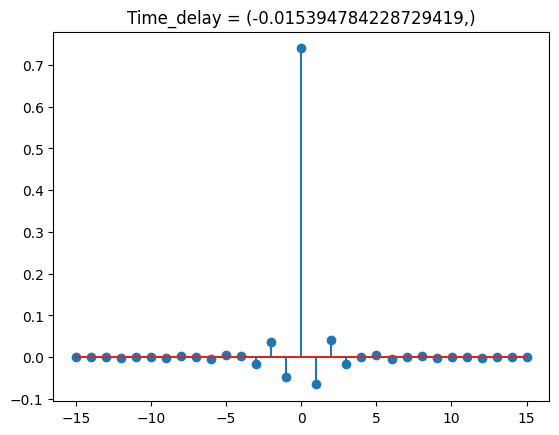

In [9]:
# complete_results = []

nakagami_m = 5 # m=1 foe reighley
OMEGA = np.sqrt(2)
AWGN_std = channel_parameters["noise_std"]

act_func = 'tanh' # 'relu'

if Normalization_mode == 'iq':
    normalization_layer = Normalization_layer_iq(name="normalization_layer")
elif Normalization_mode == 'range':
    normalization_layer = Normalization_layer_iq_range(name="normalization_layer")
elif Normalization_mode == 'msg':
    normalization_layer = L2Normalization(name="normalization_layer")

print(f"-------  start ----------")

def create_AE():
    AE = Sequential([

                    Dense(2**k, activation=act_func,input_shape=(k,)),
                    Dense(2**k, activation=act_func),
                    Dense(2*NUM_CHANNEL_USES, activation='linear',name="Encode_last_dense"),
                    #L2Normalization(name="normalization_layer"),
                    normalization_layer,
                    
                    StochasticChannelLayer("stc",NUM_CHANNEL_USES,block_size,channel_parameters), 

                    #NakagamiNoiseLayer({"omega":OMEGA,"m":nakagami_m}),
                    #keras.layers.GaussianNoise(stddev = AWGN_std),
                    #CustomNoise(mean=0.0,stddev=channel_parameters['noise_std'])
    
                    DecoderMaskLayer("Decoder_mask",channel_parameters,NUM_CHANNEL_USES),

                    Dense(2**k, activation=act_func,name="decoder_start"),
                    Dense(2**k, activation=act_func,name="decoder_middle"),
                    Dense(k, activation='sigmoid')

                    ])
    return AE

AE = create_AE()

AE.summary()


In [10]:
history = []

AE.compile(optimizer=Adam(learning_rate=1e-2),loss="binary_crossentropy")
history.append(AE.fit(x_train,y_train,batch_size=block_size,epochs=num_epoches,verbose=2,validation_data=(x_val,y_val)))
AE.compile(optimizer=Adam(learning_rate=1e-3),loss="binary_crossentropy")
history.append(AE.fit(x_train,y_train,batch_size=block_size,epochs=num_epoches,verbose=2,validation_data=(x_val,y_val)))

preds = AE.predict(x_val,batch_size=block_size)>0.5
#         accuracy = np.mean( preds == y_val  )
accuracy =  calc_block_accuracy(preds,y_val)
print(f"validation accuracy = {accuracy}")
print(f"EbNo = {EbNo_dB}")

Epoch 1/10
normalize output shape 1 =  (320, 2)
normalize output shape 2 =  (320, 2)
CFO_off = 0.0002
Phase offset =  0.6478008398815054
normalize output shape 1 =  (320, 2)
normalize output shape 2 =  (320, 2)
CFO_off = 0.0002
Phase offset =  0.6478008398815054
normalize output shape 1 =  (320, 2)
normalize output shape 2 =  (320, 2)
CFO_off = 0.0002
Phase offset =  0.6478008398815054
1000/1000 - 13s - loss: 0.3470 - val_loss: 0.2860 - 13s/epoch - 13ms/step
Epoch 2/10
1000/1000 - 3s - loss: 0.3226 - val_loss: 0.2830 - 3s/epoch - 3ms/step
Epoch 3/10
1000/1000 - 3s - loss: 0.3221 - val_loss: 0.2839 - 3s/epoch - 3ms/step
Epoch 4/10
1000/1000 - 3s - loss: 0.3227 - val_loss: 0.2843 - 3s/epoch - 3ms/step
Epoch 5/10
1000/1000 - 3s - loss: 0.3218 - val_loss: 0.2829 - 3s/epoch - 3ms/step
Epoch 6/10
1000/1000 - 3s - loss: 0.3219 - val_loss: 0.2819 - 3s/epoch - 3ms/step
Epoch 7/10
1000/1000 - 3s - loss: 0.3223 - val_loss: 0.2835 - 3s/epoch - 3ms/step
Epoch 8/10
1000/1000 - 4s - loss: 0.3220 - va

In [11]:
def all_possible_k_bits_array(k):
    x = np.zeros((2**k,k),dtype=int)
    for i in range(2**k):
        x[i] = np.array([int(a) for a in bin(i)[2:].zfill(k)])
    return x

(8, 3)


normalize output shape 1 =  (None, 2)
normalize output shape 2 =  (None, 2)
1/1 [==============================] - 0s 132ms/step
enc_shape =  (8, 2)


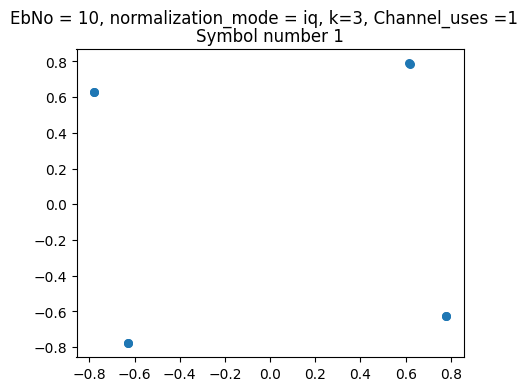

In [12]:
before_channel = Model(inputs=AE.input,
                                 outputs=AE.get_layer('normalization_layer').output)

#x = np.array(np.random.rand(block_size,k)>0.5).astype(np.float32)
x = all_possible_k_bits_array(k)
print(x.shape)
enc=before_channel.predict(x)
print("enc_shape = ",enc.shape)

fig, ax = plt.subplots(NUM_CHANNEL_USES,figsize =(5,4*NUM_CHANNEL_USES))
fig.suptitle(f"EbNo = {EbNo_dB}, normalization_mode = {Normalization_mode}, k={k}, Channel_uses ={NUM_CHANNEL_USES}")
if NUM_CHANNEL_USES>1:
    for i in range(NUM_CHANNEL_USES):
        enc_x , enc_y = enc[:,2*i],enc[:,2*i+1]
        ax[i].scatter(enc_x,enc_y,s=30)
        ax[i].set_title(f"Symbol number {1+i}")
else:
    enc_x , enc_y = enc[:,0],enc[:,1]
    ax.scatter(enc_x,enc_y,s=30)
    ax.set_title(f"Symbol number {1}")
    

normalize output shape 1 =  (32, 2)
normalize output shape 2 =  (32, 2)
100/100 [==============================] - 0s 2ms/step
CFO_off = 0.0002
Phase offset =  0.6478008398815054
10/10 [==============================] - 5s 3ms/step
CFO_off = 0.0002
Phase offset =  0.6478008398815054
10/10 [==============================] - 5s 3ms/step


Text(0.5, 0.98, 'After decoder mask with EbNo = 10dB, validation_accuracy = 0.4933125')

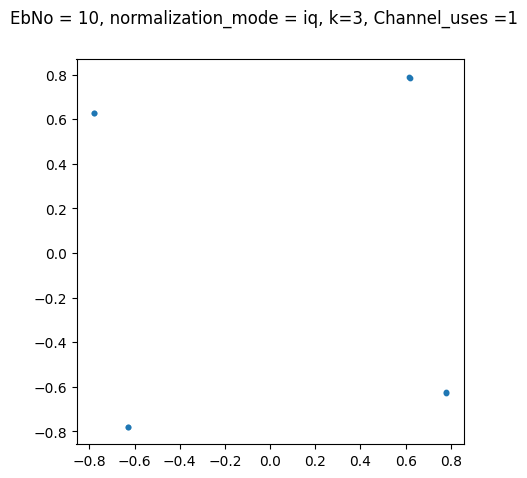

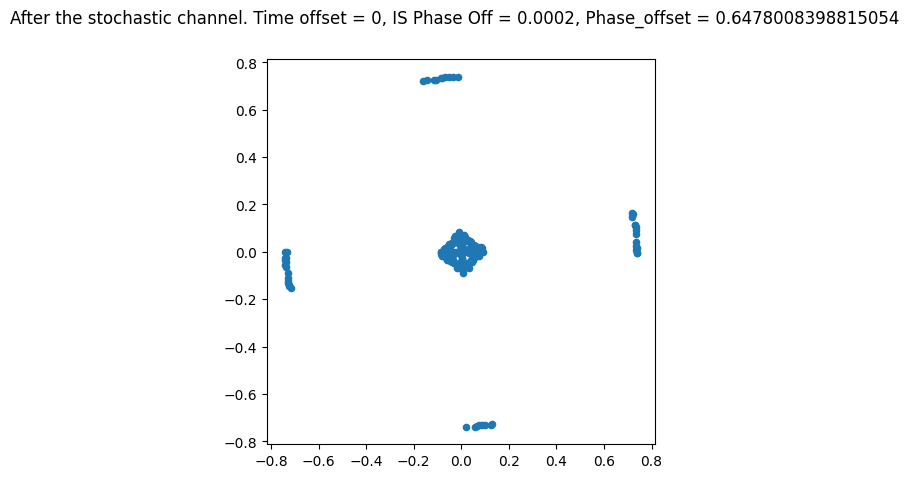

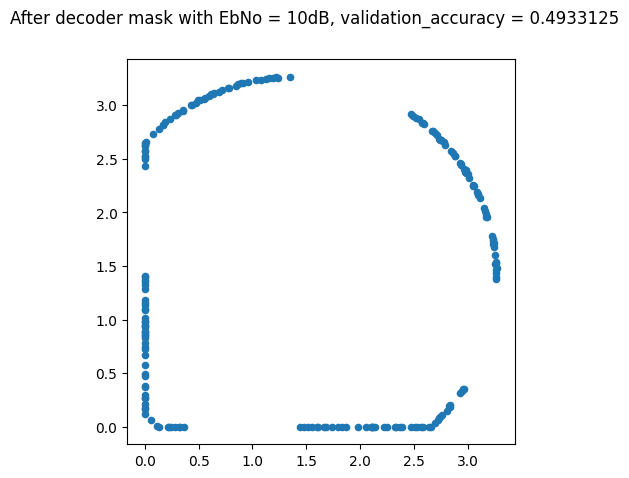

In [13]:
#Plots  

fig  = plt.figure(figsize=(5,5))
plt.scatter(np.reshape(enc,(-1,2))[:,0],np.reshape(enc,(-1,2))[:,1],s=10)
fig.suptitle(f"EbNo = {EbNo_dB}, normalization_mode = {Normalization_mode}, k={k}, Channel_uses ={NUM_CHANNEL_USES}")

x = np.array(np.random.rand(10*block_size,k)>0.5).astype(np.float32)
enc = before_channel.predict(x)

channel_model =  Model(inputs=AE.get_layer('stc').input,
                                 outputs=AE.get_layer('stc').output)

chan_out = channel_model.predict(enc,batch_size=block_size)

CFO = 2e-4
time_offset = 0

if NUM_CHANNEL_USES>1:
    fig, ax = plt.subplots(NUM_CHANNEL_USES,figsize =(5,4*NUM_CHANNEL_USES))
    fig.suptitle(f"EbNo = {EbNo_dB}dB, normalization_mode = {Normalization_mode}, k={k}, Channel_uses ={NUM_CHANNEL_USES}")
    for i in range(NUM_CHANNEL_USES):
        chan_out_x , chan_out_y = chan_out[:,2*i],chan_out[:,2*i+1]
        ax[i].scatter(chan_out_x,chan_out_y,s=10)
        ax[i].set_title(f"Symbol number ={i}, After the stochastic channel. Time offset = {time_offset}, IS Phase Off = {CFO}, Phase_offset = {channel_parameters['phase_off']}")
else:
    fig  = plt.figure(figsize=(5,5))
    chan_out_x , chan_out_y = np.reshape(chan_out,(-1,2))[:,0],np.reshape(chan_out,(-1,2))[:,1]
    plt.scatter(chan_out_x[0:200],chan_out_y[0:200],s=20)
    fig.suptitle(f"After the stochastic channel. Time offset = {time_offset}, IS Phase Off = {CFO}, Phase_offset = {channel_parameters['phase_off']}")


# After the decoder mask layer

decoder_mask = Model(inputs = AE.get_layer('stc').input, outputs = AE.get_layer('Decoder_mask').output)
dec_mask_out = decoder_mask.predict(enc,batch_size=block_size)
fig  = plt.figure(figsize=(5,5))

plt.scatter(np.reshape(dec_mask_out,(-1,2))[0:200,0],np.reshape(dec_mask_out,(-1,2))[0:200,1],s=20)
#plt.scatter(np.reshape(dec_mask_out,(-1,2))[:,0],np.reshape(dec_mask_out,(-1,2))[:,1],s=10)
fig.suptitle(f"After decoder mask with EbNo = {EbNo_dB}dB, validation_accuracy = {accuracy}")

In [14]:
x = np.array(np.random.rand(block_size,k)>0.5).astype(np.float32)
print(x)
print(AE.predict(tf.constant(x),batch_size=block_size)>0.5)

[[1. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [0. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 1. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 0.]
 [1. 1. 1.]
 [0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 1.]
 [1. 0. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]
 [1. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [1. 0. 1.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 0. 1.]
 [0. 1. 1.]
 [1. 1. 1.]
 [1. 0. 1.]
 [0. 1. 1.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 1.]
 [1. 1. 0.]
 [1. 0. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 1.]
 [1. 0. 1.]
 [0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 1.]
 [0.

### Saving model Encoder and decoder
https://www.tensorflow.org/tutorials/keras/save_and_load

In [15]:
# Save the weights
AE.save_weights('./AE_model')

### Ploting 

In [16]:
history[0].history.keys()

dict_keys(['loss', 'val_loss'])

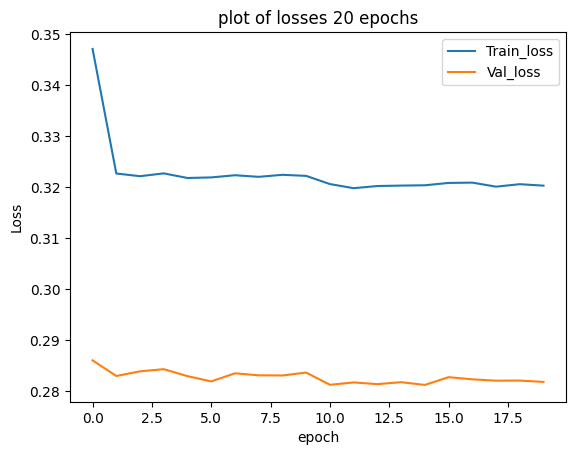

In [17]:
plt.plot(history[0].history['loss']+history[1].history['loss'])
plt.plot(history[0].history['val_loss']+history[1].history['val_loss'])
plt.title('plot of losses '+str(num_epoches*2)+' epochs')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train_loss', 'Val_loss'])
plt.show()

## Apply Nakagami effect and generate dataset

Need the encodings we present to the channel (i.e "before_channel")


In [18]:
AE_best = AE # not comparing.. we got only one

before_channel = Model(inputs=AE_best.input,
                                 outputs=AE_best.get_layer('normalization_layer').output)

# not used
after_channel = Model(inputs=AE_best.get_layer("decoder_start").input,
                                 outputs=AE_best.output)



In [19]:
def nakagami_channel_without_awgn(m, omega, num_samples):
    nakagami_var =  nakagami.rvs(m,omega,size = num_samples)
    nakagami_phase_vec = np.exp(1j*np.random.uniform(low=0.0, high=2*np.pi, size = num_samples))
    # Generate channel with noise
    channel = nakagami_var*nakagami_phase_vec
    return channel

def nakagami_channel_with_awgn(m, omega, snr_db, num_samples):
    nakagami_var =  nakagami.rvs(m,omega,size = num_samples)
    nakagami_phase_vec = np.exp(1j*np.random.uniform(low=0.0, high=2*np.pi, size = num_samples))
    noise_var = 10**(-snr_db/10)
    # Genarating random noise
    noise = np.random.normal(scale=np.sqrt(noise_var), size=num_samples)
    # Generate channel with noise
    channel = noise + nakagami_var*nakagami_phase_vec
    return channel
    

In [20]:
# Creating and Adding the dataset to a csv

def add_to_csv(n_out):
    
    ##
    x_out = np.array(np.random.rand(n_out,k)<0.5).astype(np.float32)

    ##
    # get encodings given by DNN for each message in training set
    enc = before_channel(x_out)
    #print('enc.shape: ', enc.shape)

    # convert to iq_samples
    iq_samples = tf.complex(enc[:,0::2], enc[:,1::2])
    #print('iq_samples.shape: ', iq_samples.shape)

    ##
    M_POOL       = [1,1.25,1.5,1.75,2]
    OMEGA_POOL = [1.2,np.sqrt(2),1.6]
    SNR_DB_POOL  = [5.5,6,6.5]

    nakagami_chanel_coeff_tensor = []

    block_size = 320
    n_blocks = enc.shape[0] // block_size 
    for i in range(n_blocks):
        m = np.random.choice(M_POOL)
        snr_db = np.random.choice(SNR_DB_POOL)
        omega = np.random.choice(OMEGA_POOL)
        nakagami_chanel_coeff_tensor.append( nakagami_channel_with_awgn(m=m, omega=1,snr_db=snr_db, num_samples=(block_size,iq_samples.shape[1])) )

    nakagami_chanel_coeff_tensor = tf.constant(nakagami_chanel_coeff_tensor)
    #print("nakagami_chanel_coeff_tensor.shape : ",nakagami_chanel_coeff_tensor.shape)

    iq_samples_blocked = np.reshape(iq_samples,(n_blocks,block_size,-1))
    #print("iq_samples_blocked.shape : ",iq_samples_blocked.shape)


    # tested identity flow (enc == received_enc)  with : nakagami_chanel_coeff_tensor =  tf.complex(1.,0.)

    # element wise multiply
    nakagami_affected_iq_samples = tf.multiply(nakagami_chanel_coeff_tensor,iq_samples_blocked)
    # undo the blockking
    nakagami_affected_iq_samples = tf.reshape(nakagami_affected_iq_samples,(block_size*n_blocks,-1))
    #print("nakagami_affected_iq_samples.shape : ",nakagami_affected_iq_samples.shape)

    ##
    # need to convert each iq_samples to two encoding
    real_part =  tf.expand_dims(tf.math.real(nakagami_affected_iq_samples),axis=2)
    imag_part =  tf.expand_dims(tf.math.imag(nakagami_affected_iq_samples),axis=2)

    concat = tf.concat((real_part,imag_part),axis=2)
    #print("concat.shape : ",concat.shape)
    received_enc = tf.cast(tf.reshape(concat,(block_size*n_blocks,-1)),tf.float32)
    #print("received_enc.shape : ",received_enc.shape)

    ## 
    #Summary
    # enc is the encodings presenet to channel  
    # messages --> bits --> [trained DNN]  --> enc 
    #print('enc.shape: ', enc.shape)


    # received_enc is the encoding equavalent after Nakagami+noise effects considered
    # enc --> iq_samples --> [NAKAGAMI+noise effect]  --> affected_iq_smaples --> received_enc
    #print('received_enc.shape: ', received_enc.shape)

    # see the difference done by the channel
    enc - received_enc

    ##
    ## Adding to csv file
    enc = np.reshape(enc,(-1,1))
    received_enc = np.reshape(received_enc,(-1,1))
    #print(enc.shape)
    data = np.concatenate((enc,received_enc),axis=1)
   #print(data.shape)
    df = pd.DataFrame(data)  
    df.to_csv("my_data_.csv", mode = 'a',index=False, header=False) 


### Loading model

time_delay -  (-0.022254480714422487,)
normalize output shape 1 =  (None, 2)
normalize output shape 2 =  (None, 2)
CFO_off = 0.0002
Phase offset =  0.6478008398815054


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense_input'), name='dense_input', description="created by layer 'dense_input'") at layer "dense". The following previous layers were accessed without issue: []

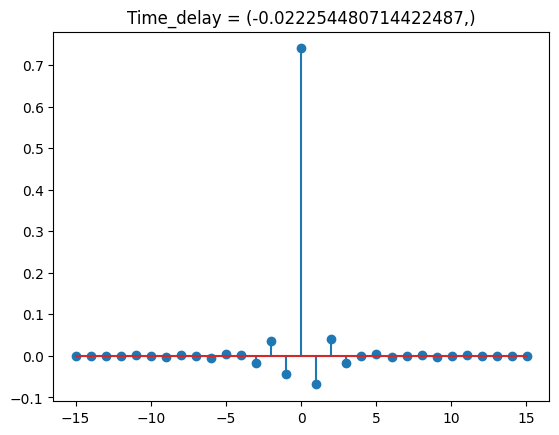

In [21]:
AE_load = create_AE()
AE_load.load_weights('./AE_model')

before_channel = Model(inputs=AE_load.input,
                                 outputs=AE_load.get_layer('normalization_layer').output)

# not used
after_channel = Model(inputs=AE_load.get_layer("decoder_start").input,
                                 outputs=AE_load.output)

In [ ]:
 ##
n_out = 2
block_size=1
x_out = np.array(np.random.rand(n_out,k)<0.5).astype(np.float32)

##
# get encodings given by DNN for each message in training set
enc = before_channel(x_out)
#print('enc.shape: ', enc.shape)

# convert to iq_samples
iq_samples = tf.complex(enc[:,0::2], enc[:,1::2])
#print('iq_samples.shape: ', iq_samples.shape)

##
M_POOL       = [0.5,1,1.5]
SNR_DB_POOL  = [1,3,6]

nakagami_chanel_coeff_tensor = []

n_blocks = enc.shape[0] // block_size 
for i in range(n_blocks):
    m = np.random.choice(M_POOL)
    snr_db = np.random.choice(SNR_DB_POOL)
    nakagami_chanel_coeff_tensor.append( nakagami_channel_with_awgn(m=m, omega=1,snr_db=snr_db, num_samples=(block_size,iq_samples.shape[1])) )

nakagami_chanel_coeff_tensor = tf.constant(nakagami_chanel_coeff_tensor)
#print("nakagami_chanel_coeff_tensor.shape : ",nakagami_chanel_coeff_tensor.shape)

iq_samples_blocked = np.reshape(iq_samples,(n_blocks,block_size,-1))
#print("iq_samples_blocked.shape : ",iq_samples_blocked.shape)


# tested identity flow (enc == received_enc)  with : nakagami_chanel_coeff_tensor =  tf.complex(1.,0.)

# element wise multiply
nakagami_affected_iq_samples = tf.multiply(nakagami_chanel_coeff_tensor,iq_samples_blocked)
# undo the blockking
nakagami_affected_iq_samples = tf.reshape(nakagami_affected_iq_samples,(block_size*n_blocks,-1))
#print("nakagami_affected_iq_samples.shape : ",nakagami_affected_iq_samples.shape)

##
# need to convert each iq_samples to two encoding
real_part =  tf.expand_dims(tf.math.real(nakagami_affected_iq_samples),axis=2)
imag_part =  tf.expand_dims(tf.math.imag(nakagami_affected_iq_samples),axis=2)

concat = tf.concat((real_part,imag_part),axis=2)
#print("concat.shape : ",concat.shape)
received_enc = tf.cast(tf.reshape(concat,(block_size*n_blocks,-1)),tf.float32)
#print("received_enc.shape : ",received_enc.shape)

## 
#Summary
# enc is the encodings presenet to channel  
# messages --> bits --> [trained DNN]  --> enc 
#print('enc.shape: ', enc.shape)


# received_enc is the encoding equavalent after Nakagami+noise effects considered
# enc --> iq_samples --> [NAKAGAMI+noise effect]  --> affected_iq_smaples --> received_enc
#print('received_enc.shape: ', received_enc.shape)

# see the difference done by the channel
enc - received_enc

##
## Adding to csv file
enc = np.reshape(enc,(-1,1))
received_enc = np.reshape(received_enc,(-1,1))
#print(enc.shape)
data = np.concatenate((enc,received_enc),axis=1)
#print(data.shape)
df = pd.DataFrame(data) 

i = 0
print(np.array2string(x_out[i]))
print(np.array2string(enc[i]))
print(np.array2string(received_enc[i]))
print(np.array2string(enc[i]-received_enc[i]))

NameError: name 'before_channel' is not defined